# HITL + Energy Consumption Model

Episode 362, State: [0. 0. 0. 0. 0. 0.]
Number of agents inside: 0
values:  [ 0.32  0.13 -0.08  0.31  0.13  0.32  0.32  0.31  0.49  0.13 -0.08  0.32
  0.49 -0.08]
Predicted Comfort:  0
Power Consumed:  -89.78040000000021
Formula for Sum:  -89.78040000000021
Formula for Mean:  -89.78040000000021
values:  [0.49 0.32 0.13 0.48 0.32 0.5  0.49 0.48 0.65 0.32 0.13 0.49 0.65 0.13]
Predicted Comfort:  -2
Power Consumed:  -0.0
Formula for Sum:  -32670.732634971715
Formula for Mean:  -32670.732634971715
RL Reward: -89.78040000000021
Fixed Reward: -32670.732634971715
values:  [ 0.32  0.13 -0.08  0.31  0.13  0.32  0.32  0.31  0.49  0.13 -0.08  0.32
  0.49 -0.08]
Episode 362, State: [2.98e+01 0.00e+00 1.40e+01 1.40e+01 3.78e+04 2.54e+01]
Number of agents inside: 14
values:  [ 0.32  0.13 -0.08  0.31  0.13  0.32  0.32  0.31  0.49  0.13 -0.08  0.32
  0.49 -0.08  0.32  0.49  0.32  0.49 -0.08  0.32  0.31  0.49  0.13  0.32
  0.13  0.31  0.49  0.49  0.32  0.31  0.32 -0.08 -0.08  0.49  0.13]
Predicted Comf

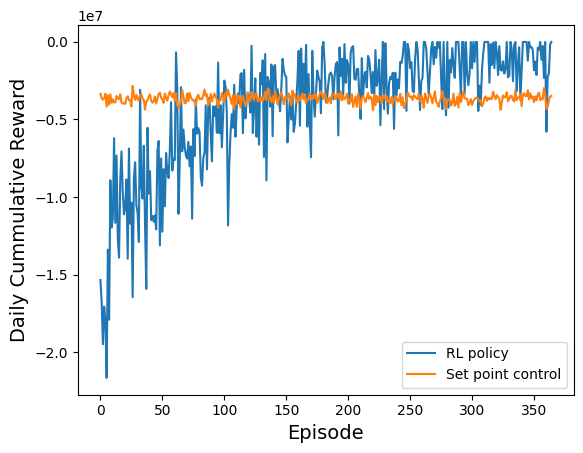

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

RL Policy Rewards: [-15353310.37914599, -16812578.28161776, -19489697.818371784, -17064596.203519486, -17951403.088488664, -21658193.017815016, -13398800.93887034, -17906565.750521332, -8920962.415106399, -11969670.86426418, -11399613.723477582, -6207021.4055836545, -11664104.064942637, -7332745.38843176, -12674014.909692634, -13909445.225031238, -8866413.410753226, -7068951.183403044, -9631547.549528684, -11119156.199773185, -10686115.243163006, -8870197.128436714, -13981060.94624375, -6879141.032357699, -11716046.51921855, -10366513.582540588, -16458413.786029419, -8817973.823688721, -7767028.283909375, -10537214.038350949, -11015169.982529465, -12896566.225336287, -3101720.6721378556, -9332686.710154217, -10105252.368036311, -6702623.452754418, -11849109.750073554, -15916203.744791677, -5544570.095868221, -9777936.543773064, -8342416.805864586, -11492998.585352102, -11211978.978981065, -11597019.398596738, -11183192.822433462, -12085888.98922797, -7029531.526745367, -6394536.0131091

In [6]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from simulation import Simulation

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

model_complexity = 256
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, model_complexity)
        self.layer2 = nn.Linear(model_complexity, model_complexity)
        self.layer4 = nn.Linear(model_complexity, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer4(x)


class ActionSpace():
    def __init__(self):
        self.true_action_space = np.round(np.arange(20, 28, 0.2), 2)
        self.action_space = np.arange(0, len(self.true_action_space), 1) 
        self.n = len(self.action_space)

    def convert(self, n):
        return self.true_action_space[n]
    
    def sample(self):
        return round(self.action_space[np.random.randint(0, self.n)], 2)
    
action_space = ActionSpace()

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.005
LR = 1e-4

policy_net = None
target_net = None
optimizer = None
memory = ReplayMemory(100000)

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:   
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long)

rl_rsts = []
fixed_rsts = []

def plot_durations(show_result=False):
    plt.figure(1)
    
    if not show_result:
        plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Daily Cummulative Reward', fontsize=14)
    plt.plot(rl_rsts)
    plt.plot(fixed_rsts)
    plt.legend(["RL policy", "Set point control"])
    
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

num_episodes = 365 # standard training limit?
fixed_rsts, rl_rsts = [], []

class Runner():
    def __init__(self, simulator, complexity=256):
        global sim, model_complexity, policy_net, target_net, optimizer, n_actions, n_observations
        sim = simulator
        model_complexity = complexity

        state = sim.reset()
        n_observations = len(state)
        n_actions = action_space.n

        policy_net = DQN(n_observations, n_actions).to(device)
        target_net = DQN(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
        
    def run(self):
        for i_episode in range(num_episodes):
            state = sim.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            past_actions = []
            while not sim.is_terminate:
                print(f"Episode {i_episode + 1}, State: {state.squeeze().cpu().numpy()}")
                print(f"Number of agents inside: {len(sim.agents_in)}")  #printing sim.agents_in
                action = select_action(state)
                past_actions.append(action_space.convert(action.item()))
                observation, reward, done = sim.step(action_space.convert(action.item()))
                reward = torch.tensor([reward], device=device)
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                memory.push(state, action, next_state, reward)

                state = next_state

                optimize_model()

                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
                target_net.load_state_dict(target_net_state_dict)
            
            rl, fixed = sim.get_cummulative_reward()
            rl_rsts.append(rl)
            fixed_rsts.append(fixed)
            print(f"Episode {i_episode + 1}, RL Reward: {rl}, Fixed Reward: {fixed}")
            
            if i_episode % 5 == 0:
                plot_durations()
            
        print('Complete')
        plot_durations(show_result=True)
        plt.ioff()
        plt.show()
        
        torch.save(policy_net.state_dict(), 'hitl_model.pth')
        
        return rl_rsts, fixed_rsts, policy_net

sim = Simulation(num_days=1, is_render=False, alpha=0.8, beta=1)
runner = Runner(simulator=sim, complexity=256)
rl_train_rsts, fixed_train_rsts, policy_tc = runner.run()

print("RL Policy Rewards:", rl_train_rsts)
print("Fixed Policy Rewards:", fixed_train_rsts)

# Energy Consumption Model

Episode 362, State: [0. 0. 0. 0. 0. 0.]
Number of agents inside: 0
values:  [-0.03 -0.24 -0.03 -0.03 -0.23 -0.48 -0.03  0.17 -0.03 -0.23 -0.23 -0.48
 -0.03]
Predicted Comfort:  0
Power Consumed:  -269.34120000000013
Formula for Sum:  -269.34120000000013
Formula for Mean:  -269.34120000000013
values:  [0.48 0.32 0.5  0.5  0.32 0.13 0.5  0.65 0.5  0.32 0.32 0.13 0.5 ]
Predicted Comfort:  -1
Power Consumed:  -0.0
Formula for Sum:  -16826.847207859468
Formula for Mean:  -16826.847207859468
RL Reward: -269.34120000000013
Fixed Reward: -16826.847207859468
values:  [-0.03 -0.24 -0.03 -0.03 -0.23 -0.48 -0.03  0.17 -0.03 -0.23 -0.23 -0.48
 -0.03]
Episode 362, State: [2.88e+01 0.00e+00 1.30e+01 1.30e+01 3.78e+04 2.42e+01]
Number of agents inside: 13
values:  [ 0.09 -0.12  0.08  0.08 -0.11 -0.35  0.08  0.27  0.08 -0.11 -0.11 -0.35
  0.08  0.09  0.09  0.08  0.27  0.09  0.09  0.09  0.27 -0.12  0.09 -0.12
  0.09  0.09  0.09  0.09  0.09  0.27 -0.11  0.09]
Predicted Comfort:  0
Power Consumed:  -628.4

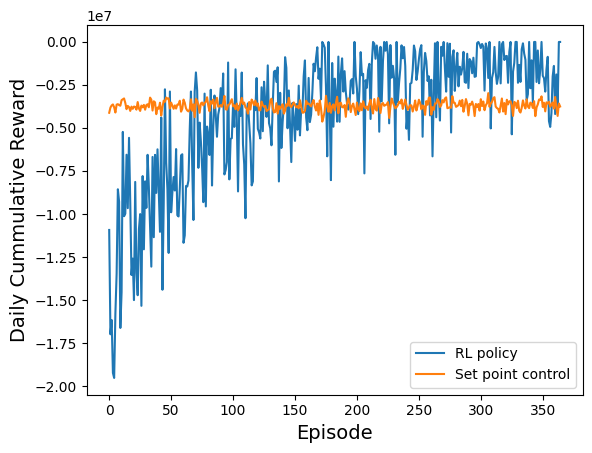

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

RL Policy Rewards: [-10925503.238083167, -16980843.868343387, -16154098.512763746, -19222030.463808328, -19513667.149082374, -15765121.88918938, -13461454.096594736, -8564291.398344819, -9290080.7546799, -16613452.834447963, -14531195.83187418, -5235124.06537974, -10126603.777327629, -9977955.9168966, -6559197.404001623, -9658404.345705958, -5577688.701860143, -9346587.234095352, -13539328.972327413, -12587450.020825978, -14994574.066513414, -8137375.828280055, -13399267.79291137, -14713107.852922423, -10883617.221003184, -10004248.980735576, -15328526.819222929, -7798121.956131733, -12049252.872135213, -8104731.641080452, -9644324.5204014, -6563855.885785665, -8425162.017926788, -10822899.755856879, -13054143.633757593, -6687598.654115979, -11345445.83761719, -6566775.109065711, -8774428.903890925, -6245993.128581581, -8540701.592815416, -11034182.2687054, -4396660.156740655, -14395494.400713775, -9429529.697447821, -2761969.234146062, -6999648.543890962, -8557139.891010243, -12258938

In [7]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from simulation import Simulation

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

model_complexity = 256
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, model_complexity)
        self.layer2 = nn.Linear(model_complexity, model_complexity)
        self.layer4 = nn.Linear(model_complexity, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer4(x)


class ActionSpace():
    def __init__(self):
        self.true_action_space = np.round(np.arange(20, 28, 0.2), 2)
        self.action_space = np.arange(0, len(self.true_action_space), 1) 
        self.n = len(self.action_space)

    def convert(self, n):
        return self.true_action_space[n]
    
    def sample(self):
        return round(self.action_space[np.random.randint(0, self.n)], 2)
    
action_space = ActionSpace()

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.005
LR = 1e-4

policy_net = None
target_net = None
optimizer = None
memory = ReplayMemory(100000)

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:   
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long)

rl_rsts = []
fixed_rsts = []

def plot_durations(show_result=False):
    plt.figure(1)
    
    if not show_result:
        plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Daily Cummulative Reward', fontsize=14)
    plt.plot(rl_rsts)
    plt.plot(fixed_rsts)
    plt.legend(["RL policy", "Set point control"])
    
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

num_episodes = 365 # standard training limit?
fixed_rsts, rl_rsts = [], []

class Runner():
    def __init__(self, simulator, complexity=256):
        global sim, model_complexity, policy_net, target_net, optimizer, n_actions, n_observations
        sim = simulator
        model_complexity = complexity

        state = sim.reset()
        n_observations = len(state)
        n_actions = action_space.n

        policy_net = DQN(n_observations, n_actions).to(device)
        target_net = DQN(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
        
    def run(self):
        for i_episode in range(num_episodes):
            state = sim.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            past_actions = []
            while not sim.is_terminate:
                print(f"Episode {i_episode + 1}, State: {state.squeeze().cpu().numpy()}")
                print(f"Number of agents inside: {len(sim.agents_in)}")  #printing sim.agents_in
                action = select_action(state)
                past_actions.append(action_space.convert(action.item()))
                observation, reward, done = sim.step(action_space.convert(action.item()))
                reward = torch.tensor([reward], device=device)
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                memory.push(state, action, next_state, reward)

                state = next_state

                optimize_model()

                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
                target_net.load_state_dict(target_net_state_dict)
            
            rl, fixed = sim.get_cummulative_reward()
            rl_rsts.append(rl)
            fixed_rsts.append(fixed)
            print(f"Episode {i_episode + 1}, RL Reward: {rl}, Fixed Reward: {fixed}")
            
            if i_episode % 5 == 0:
                plot_durations()
            
        print('Complete')
        plot_durations(show_result=True)
        plt.ioff()
        plt.show()
        
        torch.save(policy_net.state_dict(), 'energy_model.pth')
        
        return rl_rsts, fixed_rsts, policy_net

sim = Simulation(num_days=1, is_render=False, alpha=0.8, beta=1)
runner = Runner(simulator=sim, complexity=256)
rl_train_rsts, fixed_train_rsts, policy_tc = runner.run()

print("RL Policy Rewards:", rl_train_rsts)
print("Fixed Policy Rewards:", fixed_train_rsts)

# Continuous Learning?

In [2]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from simulation import Simulation

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

model_complexity = 256
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, model_complexity)
        self.layer2 = nn.Linear(model_complexity, model_complexity)  # Fixed this
        self.layer4 = nn.Linear(model_complexity, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer4(x)

class ActionSpace():
    def __init__(self):
        self.true_action_space = np.round(np.arange(20, 28, 0.2), 2)
        self.action_space = np.arange(0, len(self.true_action_space), 1) 
        self.n = len(self.action_space)

    def convert(self, n):
        return self.true_action_space[n]
    
    def sample(self):
        return round(self.action_space[np.random.randint(0, self.n)], 2)
    
action_space = ActionSpace()

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.005
LR = 1e-4

policy_net = None
target_net = None
optimizer = None
memory = ReplayMemory(100000)

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:   
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long)

rl_rsts = []
fixed_rsts = []

def plot_durations(show_result=False):
    plt.figure(1)
    
    if not show_result:
        plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Daily Cumulative Reward', fontsize=14)
    plt.plot(rl_rsts)
    plt.plot(fixed_rsts)
    plt.legend(["RL policy", "Set point control"])
    
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#modified runner function to incorporate continuous learning
class Runner():
    def __init__(self, simulator, complexity=256):
        global sim, model_complexity, policy_net, target_net, optimizer, n_actions, n_observations
        sim = simulator
        model_complexity = complexity

        state = sim.reset()
        n_observations = len(state)
        n_actions = action_space.n

        policy_net = DQN(n_observations, n_actions).to(device)
        target_net = DQN(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
        
    def run(self):
        episode_count = 0
        try:
            while True:
                episode_count += 1
                state = sim.reset()
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                past_actions = []
                while not sim.is_terminate:
                    print(f"Episode {episode_count}, State: {state.squeeze().cpu().numpy()}")
                    print(f"Number of agents inside: {len(sim.agents_in)}")  #printing sim.agents_in
                    action = select_action(state)
                    past_actions.append(action_space.convert(action.item()))
                    observation, reward, done = sim.step(action_space.convert(action.item()))
                    reward = torch.tensor([reward], device=device)
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                    memory.push(state, action, next_state, reward)

                    state = next_state

                    optimize_model()

                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
                    target_net.load_state_dict(target_net_state_dict)
                
                rl, fixed = sim.get_cummulative_reward()
                rl_rsts.append(rl)
                fixed_rsts.append(fixed)
                print(f"Episode {episode_count}, RL Reward: {rl}, Fixed Reward: {fixed}")
                
                if episode_count % 5 == 0:
                    plot_durations()
                
                #save every 50 episodes?
                if episode_count % 50 == 0:
                    torch.save(policy_net.state_dict(), f'hitl_model_{episode_count}.pth')
            
        except KeyboardInterrupt:
            print("Training interrupted. Saving model...")
            torch.save(policy_net.state_dict(), 'hitl_model.pth')
            plot_durations(show_result=True)
            plt.ioff()
            plt.show()
            return rl_rsts, fixed_rsts, policy_net

sim = Simulation(num_days=1, is_render=False, alpha=0.8, beta=1)
runner = Runner(simulator=sim, complexity=256)
rl_train_rsts, fixed_train_rsts, policy_tc = runner.run()
print("RL Policy Rewards:", rl_train_rsts)
print("Fixed Policy Rewards:", fixed_train_rsts)

Episode 571, State: [0. 0. 0. 0. 0. 0.]
Number of agents inside: 0
values:  [0.2  0.38 0.2  0.38 0.38 0.38 0.2 ]
values:  [0.32 0.49 0.32 0.49 0.49 0.5  0.32]
values:  [0.2  0.38 0.2  0.38 0.38 0.38 0.2 ]
Episode 571, State: [2.80e+01 0.00e+00 7.00e+00 7.00e+00 3.78e+04 2.56e+01]
Number of agents inside: 7
values:  [ 0.13  0.32  0.13  0.32  0.32  0.32  0.13  0.32  0.13 -0.08  0.13  0.32
  0.31  0.13  0.13  0.13 -0.08  0.13  0.49  0.49  0.13  0.32  0.49]
values:  [0.32 0.49 0.32 0.49 0.49 0.5  0.32 0.49 0.32 0.13 0.32 0.5  0.48 0.32
 0.32 0.32 0.13 0.32 0.65 0.65 0.32 0.5  0.65]
values:  [ 0.13  0.32  0.13  0.32  0.32  0.32  0.13  0.32  0.13 -0.08  0.13  0.32
  0.31  0.13  0.13  0.13 -0.08  0.13  0.49  0.49  0.13  0.32  0.49]
Episode 571, State: [2.95e+01 0.00e+00 2.30e+01 2.30e+01 3.96e+04 2.54e+01]
Number of agents inside: 23
values:  [ 0.21  0.01  0.21  0.21  0.2   0.01  0.21  0.01 -0.21  0.01  0.2   0.2
  0.01  0.01  0.01 -0.21  0.01  0.38  0.38  0.01  0.2   0.38 -0.21  0.2
  0.38  